In [5]:
import os
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
from numpy import *  
from keras.models import Sequential
from keras.layers import Convolution2D, Reshape, Dense, Dropout, Convolution1D, Activation, GlobalMaxPooling1D, LSTM, Conv1D, MaxPooling1D, Activation
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import regularizers
from keras import losses


In [6]:
def loadData(loadfile):  
    train_x = []  
    train_y = []  
    fileIn = pandas.read_csv(loadfile)  
    
    train_x = fileIn[['cos_sim', 'euclidean_dist','kl_list']].values
    train_y = pd.get_dummies(fileIn['Stance'].values)
    train_x = np.expand_dims(train_x, axis=1)
    return train_x, train_y

In [7]:
x_train, y_train = loadData('dataset/fnc-1/split/train_stances_sim.csv')

In [8]:
print(y_train.shape)
print(x_train.shape)

(44974, 4)
(44974, 1, 3)


In [59]:
model = Sequential()
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
hidden_dims = 280
model.add(LSTM(32, return_sequences=True,
               input_shape=(1, x_train.shape[2]), kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.4))
model.add(LSTM(128))  # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 32)             4608      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 87,556
Trainable params: 87,556
Non-trainable params: 0
_________________________________________________________________


In [60]:
earlystopper = EarlyStopping(monitor='loss', patience=2, verbose=0)

history = model.fit(x_train, y_train,
          epochs=5,
          batch_size=64,
          callbacks=[earlystopper])


Epoch 1/5
44974/44974 [==============================] - 10s 213us/step - loss: 0.4410 - acc: 0.8648
Epoch 2/5
44974/44974 [==============================] - 6s 144us/step - loss: 0.3512 - acc: 0.8657
Epoch 3/5
44974/44974 [==============================] - 6s 143us/step - loss: 0.3021 - acc: 0.8894
Epoch 4/5
44974/44974 [==============================] - 6s 135us/step - loss: 0.2483 - acc: 0.9178
Epoch 5/5
44974/44974 [==============================] - 6s 141us/step - loss: 0.2283 - acc: 0.9242


In [61]:
x_valid, y_valid = loadData('dataset/fnc-1/split/validation_stances_sim.csv')
prob_y_valid = model.predict(x_valid, batch_size=64)
result = prob_y_valid.argmax(1)
print(prob_y_valid.argmax(1))

[3 3 3 ... 2 2 2]


In [62]:
fileIn = pandas.read_csv('dataset/fnc-1/split/validation_stances_sim.csv')
valid_stances = fileIn['Stance'].values

In [63]:
result_stance = []
for i in range(len(result)):
    if result[i] == 0:
        result_stance.append('agree')
    elif result[i] == 1:
        result_stance.append('disagree')
    elif result[i] == 2:
        result_stance.append('discuss')
    else:
        result_stance.append('unrelated')

print('test accuracy:', sum(result_stance == valid_stances)/ len(result_stance))

test accuracy: 0.8619447779111644


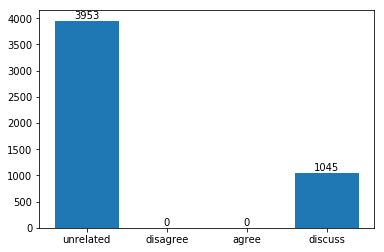

In [64]:
result_sum = []
result_sum.append(sum(np.array(result_stance) == 'unrelated'))
result_sum.append(sum(np.array(result_stance) == 'disagree'))
result_sum.append(sum(np.array(result_stance) == 'agree'))
result_sum.append(sum(np.array(result_stance) == 'discuss'))
plt.bar(['unrelated', 'disagree', 'agree', 'discuss'], result_sum)  
for a,b in zip(['unrelated', 'disagree', 'agree', 'discuss'], result_sum):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.show() 